# Load Data

In [2]:
import pandas as pd

predicted_data_puskesmas = pd.read_csv("predicted-review.csv")

predicted_data_puskesmas.head()

,reviewer_name,rating,review_text,puskesmas_name,cleaned_review_text,language,is_positive
0,Mira Diah V,5,Pelayanan di poli KIA bagus&informatif sekali....,Puskesmas Simomulyo,layan pol kia bagusinformatif anak imunisasi a...,id,1
1,Ranitya Dewi Ayu Sadian,1,Pelayanan poli KIA lama sekali…\nKamis pagi se...,Puskesmas Simomulyo,layan pol kia kamis pagi puskesmas daftar pol ...,id,0
2,Yuliasti Ika,5,"Puskesmas dengan pelayanan yang baik sekali, s...",Puskesmas Simomulyo,puskesmas layan layan ramah lengkap fasilitas ...,id,1
3,Yusup Jaya,1,"Pelayanan tambah lelet, mohon managentnya di p...",Puskesmas Simomulyo,layan lambat mohon managernya sat set rujuk ce...,id,0
4,Yunia Ardina,1,Saya mau kasih masukan sekaligus protes..\n\nS...,Puskesmas Simomulyo,kasih masuk protes tanggal february jaman prik...,id,0


In [3]:
detail_puskesmas = pd.read_csv("scrapping/cleaned_puskesmas.csv")

detail_puskesmas.head()

,name,kepala puskesmas,alamat,telepon,url,rate,review_num
0,Puskesmas Asemrowo,dr. Diah Miryati,Jln. Asem Raya No. 8,(031) 5456122 / 081252965070,https://www.google.com/maps/place/Puskesmas+As...,"3,5",(131)
1,Puskesmas Balas Klumprik,"dr. Yessy Pebriaty Sukatendel, MM",Jln. Raya Balas Klumprik,(031) 7665219,https://www.google.com/maps/place/Puskesmas+Ba...,"4,1",(96)
2,Puskesmas Balongsari,dr. Dewi Ayuning Asih,Jln. Balongsari Tama No. 2 Surabaya,(031) 7417104,https://www.google.com/maps/place/Puskesmas+Ba...,"3,9",(308)
3,Puskesmas Bangkingan,dr. Tri Indah Rachmawati,Jln. Banyu Urip Kidul 6/8,(031) 5685424 - 5615292 / 081334932007,https://www.google.com/maps/place/Puskesmas+Ba...,"3,8",(84)
4,Puskesmas Banyu Urip,"dr. Winartuti Santoso, M.Kes",Jln. Banyu Urip Kidul 6/8,(031) 7405936,https://www.google.com/maps/place/Puskesmas+Ba...,"3,2",(170)


# Get longtiude and latitude of each puskesmas

In [4]:
import plotly.express as px
from tqdm.notebook import tqdm
import requests
import random


def get_lat_lon(puskesmas_name):
    user_agents = [
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3",
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15",
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:88.0) Gecko/20100101 Firefox/88.0",
        "Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.110 Mobile Safari/537.36",
        "Mozilla/5.0 (iPad; CPU OS 13_7 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.2 Mobile/15E148 Safari/604.1",
    ]
    attempts = 0
    while attempts < 10:
        try:
            headers = {"User-Agent": random.choice(user_agents)}
            url = f"https://nominatim.openstreetmap.org/search?q={puskesmas_name}, surabaya&format=jsonv2"
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                data = response.json()
                return data[0]["lat"], data[0]["lon"], data[0]["display_name"]
            else:
                attempts += 1
                # print(f"Attempt {attempts}: Failed to get data for {puskesmas_name}")
        except Exception as e:
            attempts += 1
            # print(f"Attempt {attempts}: Error for {puskesmas_name} - {e}")
    return None, None


tqdm.pandas()
detail_puskesmas["lat"], detail_puskesmas["lon"], detail_puskesmas["display_name"] = (
    zip(*detail_puskesmas["name"].progress_apply(get_lat_lon))
)

print(detail_puskesmas.columns)

detail_puskesmas = detail_puskesmas.rename(columns={"name": "puskesmas_name"})

positive_review_counts = predicted_data_puskesmas.groupby("puskesmas_name")[
    "is_positive"
].sum()
total_review_counts = predicted_data_puskesmas.groupby("puskesmas_name")[
    "is_positive"
].count()
percentage_positive_reviews = (
    positive_review_counts / total_review_counts * 100
).reset_index()
percentage_positive_reviews.columns = ["puskesmas_name", "positive_percentage"]

detail_puskesmas = detail_puskesmas.merge(
    percentage_positive_reviews, on="puskesmas_name", how="left"
)

  0%|          | 0/63 [00:00<?, ?it/s]

Index(['name', 'kepala puskesmas', 'alamat', 'telepon', 'url', 'rate',
       'review_num', 'lat', 'lon', 'display_name'],
      dtype='object')


# Geolocation of each puskesmas reviewed from google maps

In [5]:
data_for_plotting = detail_puskesmas[
    ["lat", "lon", "puskesmas_name", "positive_percentage"]
]

data_for_plotting["lat"] = pd.to_numeric(data_for_plotting["lat"], errors="coerce")
data_for_plotting["lon"] = pd.to_numeric(data_for_plotting["lon"], errors="coerce")
data_for_plotting["positive_percentage"] = data_for_plotting[
    "positive_percentage"
].fillna(0)

data_for_plotting = data_for_plotting[data_for_plotting["positive_percentage"] != 0]

fig = px.scatter_mapbox(
    data_for_plotting,
    lat="lat",
    lon="lon",
    color="positive_percentage",
    size="positive_percentage",
    hover_name="puskesmas_name",
    hover_data={"positive_percentage": True},
    size_max=15,
    zoom=10,
    center={
        "lat": data_for_plotting["lat"].mean(),
        "lon": data_for_plotting["lon"].mean(),
    },
    mapbox_style="carto-positron",
    color_continuous_scale=px.colors.diverging.Tealrose_r,
    title="Puskesmas Positive Review Percentage",
)

fig.update_traces(marker=dict(size=64, opacity=0.7), selector=dict(mode="markers+text"))

fig.update_layout(
    legend_title_text="Positive Review %",
    title=dict(text="Puskesmas Positive Review Percentage", x=0.5, xanchor="center"),
)

fig.update_layout(width=800, height=800)
fig.show()

/tmp/ipykernel_214216/295796426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_plotting["lat"] = pd.to_numeric(data_for_plotting["lat"], errors="coerce")
/tmp/ipykernel_214216/295796426.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_plotting["lon"] = pd.to_numeric(data_for_plotting["lon"], errors="coerce")
/tmp/ipykernel_214216/295796426.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

## Top 10 Puskesmas with the positive review

In [6]:
import pandas as pd
import plotly.express as px

data_for_plotting = detail_puskesmas[
    ["lat", "lon", "puskesmas_name", "positive_percentage"]
]

data_for_plotting["lat"] = pd.to_numeric(data_for_plotting["lat"], errors="coerce")
data_for_plotting["lon"] = pd.to_numeric(data_for_plotting["lon"], errors="coerce")
data_for_plotting["positive_percentage"] = data_for_plotting[
    "positive_percentage"
].fillna(0)

data_for_plotting = data_for_plotting[data_for_plotting["positive_percentage"] != 0]

top_10_data_for_plotting = data_for_plotting.sort_values(
    by="positive_percentage", ascending=False
).head(10)

fig = px.scatter_mapbox(
    top_10_data_for_plotting,
    lat="lat",
    lon="lon",
    color="positive_percentage",
    size="positive_percentage",
    hover_name="puskesmas_name",
    hover_data={"positive_percentage": True},
    size_max=15,
    zoom=10,
    center={
        "lat": top_10_data_for_plotting["lat"].mean(),
        "lon": top_10_data_for_plotting["lon"].mean(),
    },
    mapbox_style="carto-positron", 
    color_continuous_scale=px.colors.diverging.Tealrose_r,
    title="Top 10 Puskesmas with Positive Review Percentage",
    range_color=[detail_puskesmas['positive_percentage'].min(), detail_puskesmas["positive_percentage"].max()],
)

fig.update_traces(marker=dict(size=28, opacity=0.7), textposition="top center")

fig.update_traces(
    hovertemplate="<b>%{hovertext}</b><br>Positivity Rate: %{marker.color:.2f}%"
)

fig.update_coloraxes(colorbar_title="Positivity Rate (%)")

fig.update_layout(
    legend=dict(
        title_font=dict(size=14, color="blue"),
        bgcolor="rgba(255,255,255,0.5)",
        bordercolor="Black",
        borderwidth=2,
    ),
    title=dict(
        text="Top 10 Puskesmas with Positive Review Percentage", x=0.5, xanchor="center"
    ),
    width=800,
    height=800,
)

fig.show()

/tmp/ipykernel_214216/2427489040.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_214216/2427489040.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_214216/2427489040.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Top 10 Puskesmas with the negative review

In [7]:
import pandas as pd
import plotly.express as px

data_for_plotting = detail_puskesmas[
    ["lat", "lon", "puskesmas_name", "positive_percentage"]
]

data_for_plotting["lat"] = pd.to_numeric(data_for_plotting["lat"], errors="coerce")
data_for_plotting["lon"] = pd.to_numeric(data_for_plotting["lon"], errors="coerce")
data_for_plotting["positive_percentage"] = data_for_plotting[
    "positive_percentage"
].fillna(0)

data_for_plotting = data_for_plotting[data_for_plotting["positive_percentage"] != 0]

top_10_data_for_plotting = data_for_plotting.sort_values(
    by="positive_percentage", ascending=True
).head(10)

fig = px.scatter_mapbox(
    top_10_data_for_plotting,
    lat="lat",
    lon="lon",
    color="positive_percentage",
    size="positive_percentage",
    hover_name="puskesmas_name",
    hover_data={"positive_percentage": True},
    size_max=15,
    zoom=10,
    center={
        "lat": top_10_data_for_plotting["lat"].mean(),
        "lon": top_10_data_for_plotting["lon"].mean(),
    },
    mapbox_style="carto-positron",
    color_continuous_scale=px.colors.diverging.Tealrose_r,
    title="Top 10 Puskesmas with Negative Review Percentage",
    range_color=[detail_puskesmas['positive_percentage'].min(), detail_puskesmas["positive_percentage"].max()],
)

fig.update_traces(marker=dict(size=28, opacity=0.7), textposition="top center")

fig.update_traces(
    hovertemplate="<b>%{hovertext}</b><br>Positivity Rate: %{marker.color:.2f}%",
)

fig.update_coloraxes(colorbar_title="Positivity Rate (%)")

fig.update_layout(
    legend=dict(
        title_font=dict(size=14, color="blue"),
        bgcolor="rgba(255,255,255,0.5)",
        bordercolor="Black",
        borderwidth=2,
    ),
    title=dict(
        text="Top 10 Puskesmas with Negative Review Percentage", x=0.5, xanchor="center"
    ),
    width=800,
    height=800,
)

fig.show()

/tmp/ipykernel_214216/118797639.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_214216/118797639.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_214216/118797639.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Why positive? Why negative?

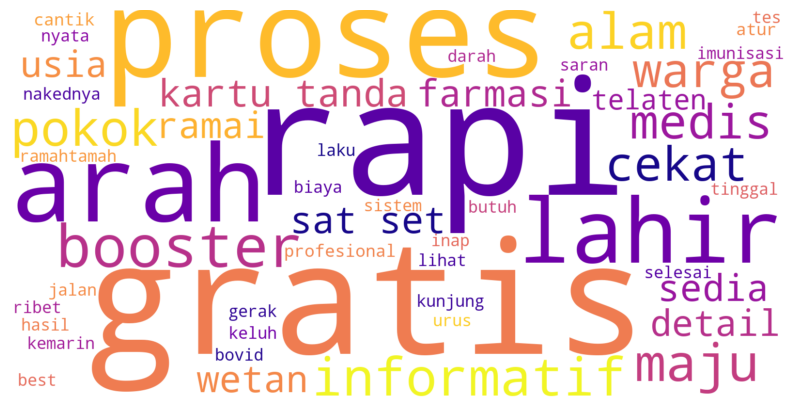

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_reviews = predicted_data_puskesmas["cleaned_review_text"]

vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

tfidf_matrix = vectorizer.fit_transform(all_reviews)

word_scores = np.sum(tfidf_matrix, axis=0)

features = vectorizer.get_feature_names_out()
scores = word_scores.A1
word_score_dict = dict(zip(features, scores))

sorted_words = sorted(word_score_dict.items(), key=lambda x: x[1], reverse=True)

positive_reviews = ' '.join(predicted_data_puskesmas[predicted_data_puskesmas['is_positive'] == 1]['cleaned_review_text'])

N = 100
common_words = set([word for word, score in sorted_words[:N]])

filtered_positive_reviews = ' '.join([word for word in positive_reviews.split() if word not in common_words])
filtered_positive_reviews = ' '.join([word for word in filtered_positive_reviews.split() if word not in detail_puskesmas['puskesmas_name'].str.lower().str.split().str[1].values])

stop_words = ["bu", "sih", "oke", "ya", "aja", "udah", "ok", "suka", "pas", "sukses", "semangat"]

filtered_positive_reviews = ' '.join([word for word in filtered_positive_reviews.split() if word not in stop_words])

pd.Series(filtered_positive_reviews.split()).value_counts().head(20)

wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color="white",
    max_words=50, 
    colormap="plasma",
    prefer_horizontal=1.0,
).generate(filtered_positive_reviews)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [9]:
# show top 5 words and sample reviews that contain the word with minimum 20 characters that are positive
top_5_words = pd.Series(filtered_positive_reviews.split()).value_counts().head(10).index

for word in top_5_words:
    print(f"Word: {word}")
    sample_reviews = predicted_data_puskesmas[predicted_data_puskesmas['cleaned_review_text'].str.contains(word) & (predicted_data_puskesmas['is_positive'] == 1) & (predicted_data_puskesmas['cleaned_review_text'].str.len() > 50)]
    for idx, review in sample_reviews.sample(5)['review_text'].items():
        print(f'{idx}: {review}')
    
    print()

Word: wetan
525: Tempat bersih, fasilitas kesehatan lengkap, pelayanan di puskesmas sidotopo wetan dapat ditingkatkan lagi. Terima kasih
527: Pelayanannya sangat memuaskan, tenaga medisnya ramah2 dan perkembangan untuk PKM Sidotopo Wetan sangat pesat
591: Untuk pelayanan puskesmas Sidotopo Wetan sudah sangat baik dan tenaga medisnya ramah-ramah
521: Alhamdulillah,, puskesmas Sidotopo wetan skrg pelayanan nya menjadi lebih baik dan cepat,,banyak kemajuan,, pokoknya is the best,👍 …
640: Pkm sidotopo wetan tambah lebih bagus pelayananya petugas yang ramah2

Word: rapi
4012: Puskesmasnya bersih tersusun rapih,, informasi obat dari farmasinya lengkap
2587: puskesmasnya bersih, rapi, dan petugas/nakes yg melayani ramah dan murah senyum. sukses terus pkm dukuh kupang
5631: Tempatnya nyaman, bersih, dan rapi. Pelayanan di puskesmas ini juga cepat, perawatnya juga ramah saat di tanya
7961: Tempat agak bersih, walaupun ada beberapa sampah plastik makanan di bawah kursi *mungkin pasiennya yang bi

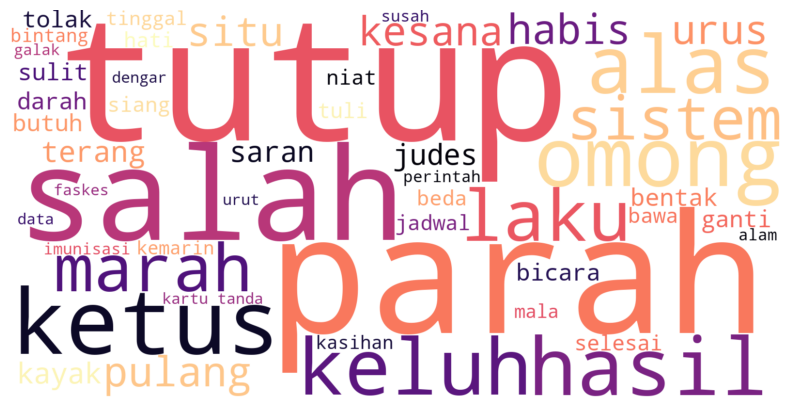

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_reviews = predicted_data_puskesmas["cleaned_review_text"]

vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

tfidf_matrix = vectorizer.fit_transform(all_reviews)

word_scores = np.sum(tfidf_matrix, axis=0)

features = vectorizer.get_feature_names_out()
scores = word_scores.A1
word_score_dict = dict(zip(features, scores))

sorted_words = sorted(word_score_dict.items(), key=lambda x: x[1], reverse=True)

negative_reviews = ' '.join(predicted_data_puskesmas[predicted_data_puskesmas['is_positive'] == 0]['cleaned_review_text'])

N = 100
common_words = set([word for word, score in sorted_words[:N]])

filtered_negative_reviews = ' '.join([word for word in negative_reviews.split() if word not in common_words])
filtered_negative_reviews = ' '.join([word for word in filtered_negative_reviews.split() if word not in detail_puskesmas['puskesmas_name'].str.lower().str.split().str[1].values])

stop_words = ["bu", "sih", "maaf", "oke", "ya", "aja", "udah", "ok", "suka", "pas", "sukses", "nyata", "ala", "tua", "jelek", "lihat", "nama", "eh"]

filtered_negative_reviews = ' '.join([word for word in filtered_negative_reviews.split() if word not in stop_words])

wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color="white",
    max_words=50,
    colormap="magma",
    prefer_horizontal=1.0,
).generate(filtered_negative_reviews)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
# show top 5 words and sample reviews that contain the word with minimum 20 characters that are negative
top_5_words = pd.Series(filtered_negative_reviews.split()).value_counts().head(10).index

for word in top_5_words:
    print(f"Word: {word}")
    sample_reviews = predicted_data_puskesmas[predicted_data_puskesmas['cleaned_review_text'].str.contains(word) & (predicted_data_puskesmas['is_positive'] == 0) & (predicted_data_puskesmas['cleaned_review_text'].str.len() > 50)]
    for idx, review in sample_reviews.sample(5)['review_text'].items():
        print(f'{idx}: {review}')
    
    print()

Word: tutup
8068: Apa benar selama puasa jam operasional berubah? karena di gerbang ditulis tutup 11.30. saya datang jam 10.53 dibilang tutup, padahal saya bawa bayi dan perlu ongkos ojek utk bisa kesini.
8542: pegawainya sbnrnya baik2 ramah2. cuma ada 1 pegawai yg songong naudzubillah. dia dibagian loket pendaftaran, laki. tp ngeselinnya ky cewe lg PMS :))) td pagi kstu, ternyta dia batuk tapi g pake masker, malah nutup mulutnya pake tangan, lanjut kerja. PADAHAL DIA NYURUH ORANG2 YG ANTRI PAKE SANITIZER. TAPI DIA NYA BEGITU. ak kasih masker baru dri tas ku. malah nunjukkin dia punya sebox. LAH TRS KNP GA DIPAKE. jgn mentang2 ini puskesmas untuk kalangan menengah kebawah jd seenaknya! kerja di lingkungan kesehatan tapi dia sendiri ga aware dgn kebersihan lingkungannya. tolong dong kasih peringatan untung pegawai ini! jangan2 dia lagi yg nularin virus di puskesmas jolotundo!
5651: Maaf nih beribu maaf
Saya mau mengajukan surat kesehatan untuk keperluan menikah di Surabaya, saya asli Ma

In [12]:
most_positive_review = detail_puskesmas.sort_values(
    "positive_percentage", ascending=False
).head(10)
most_positive_review

,puskesmas_name,kepala puskesmas,alamat,telepon,url,rate,review_num,lat,lon,display_name,positive_percentage
50,Puskesmas Sidotopo Wetan,dr. Evi Susanti,Jln. Randu 38,(031) 3767737,https://www.google.com/maps/place/Puskesmas+Si...,"4,4",(537),-7.22658925,112.76350132938722,"Puskesmas Sidotopo Wetan, Jalan Randu, RW 10, ...",82.278481
24,Puskesmas Ketabang,dr. Joyce Hestia Nugrahanti,Jln. Jaksa Agung Suprapto No 10,(031) 5311999,https://www.google.com/maps/place/Puskesmas+Ke...,"4,5",(377),-7.2580613,112.74677403040269,"Puskesmas Ketabang, Jalan Jimerto, RW 05, Keta...",78.947368
57,Puskesmas Tanjungsari,dr. Yunita Andriani,Jln. Raya Tanjungsari No.116,(031) 7497858,https://www.google.com/maps/place/Puskesmas+Ta...,"4,2",(300),-7.2594043500000005,112.6892628357994,"Puskesmas Tanjungsari, Jalan Raya Tandes Lor, ...",77.027027
56,Puskesmas Tanah Kali Kedinding,dr. Era Kartikawati,Jln. H. M. Noer 226,(031) 51501347,https://www.google.com/maps/place/Puskesmas+Ta...,"4,2",(572),-7.23037625,112.77446968315311,"Puskesmas Tanah Kali Kedinding, Jalan Kedung C...",76.288660
51,Puskesmas Simolawang,dr. Dwi Sapta Edy Purnama,Jln. Simolawang II Barat 45 A,(031) 3717433 / 085954480937,https://www.google.com/maps/place/Puskesmas+Si...,"4,2",(148),-7.2348687,112.75104985,"Puskesmas Simolawang, Jalan Simolawang Kalimir...",75.862069
42,Puskesmas Pucang Sewu,drg. Ummi Latifah,Jln. Pucang Anom Timur No. 72,(031) 5018527,https://www.google.com/maps/place/Puskesmas+Pu...,"4,4",(464),-7.28659415,112.75552826261239,"Puskesmas Pucang Sewu, Jalan Kalibokor, RW 08,...",75.242718
1,Puskesmas Balas Klumprik,"dr. Yessy Pebriaty Sukatendel, MM",Jln. Raya Balas Klumprik,(031) 7665219,https://www.google.com/maps/place/Puskesmas+Ba...,"4,1",(96),-7.3315249,112.69002720464968,"Puskesmas Balas Klumprik, Jalan Balas Klumprik...",73.684211
8,Puskesmas Dukuh Kupang,dr. Khusnul Khowatin,Jln. Dukuh Kupang 25/48,(031) 5677615,https://www.google.com/maps/place/Puskesmas+Du...,"4,0",(548),-7.2832360000000005,112.71222568060509,"Puskesmas Dukuh Kupang, Jalan Dukuh Kupang Gan...",71.565495
61,Puskesmas Wonokromo,drg. Dwiana Yuniarti,Jln. Karangrejo VI/4,(031) 8281647 / 082143561190,https://www.google.com/maps/place/Puskesmas+Wo...,"4,2",(349),-7.303176499999999,112.7303924779992,"Puskesmas Wonokromo, Jalan Karang Rejo VI, RW ...",71.502591
62,Puskesmas Wonokusumo,dr. Heri Siswanto,Jln. Wonokusumo Tengah No.55,(031) 3717597,https://www.google.com/maps/place/Puskesmas+Wo...,"4,2",(410),-7.219663649999999,112.75256160671904,"Puskesmas Wonokusumo, Jalan Wonokusumo Tengah,...",71.497585


In [13]:
most_negative_review = detail_puskesmas.sort_values(
    "positive_percentage", ascending=True
).head(10)
most_negative_review

,puskesmas_name,kepala puskesmas,alamat,telepon,url,rate,review_num,lat,lon,display_name,positive_percentage
34,Puskesmas Morokrembangan,dr. Nurul Ihsani,Jln. Tambakasri 13/7 Morokrembangan,(031) 7493259,https://www.google.com/maps/place/Puskesmas+Mo...,"1,9",(108),-7.2347805,112.71244346706712,"Puskesmas Moro Krembangab, Jalan Tambak Asri X...",10.666667
49,Puskesmas Sidotopo,dr. Galih Satryo Utomo,"Jl. Pegirian No.239, Sidotopo",(031) 3767735,https://www.google.com/maps/place/Puskesmas+Si...,"2,8",(80),-7.23034775,112.74588161903259,"Puskesmas Sidotopo, Jalan Sidodadi, RW 07, Sim...",27.659574
33,Puskesmas Mojo,"dr. Ratna Megasari, M.Kes",Jln. Mojo Klanggru Wetan 2/11,(031) 5932332,https://www.google.com/maps/place/Puskesmas+Mo...,"2,6",(285),-7.2709021499999995,112.77082440581847,"Puskesmas Mojo Surabaya, Jalan Mojo Klanggru W...",31.606218
22,Puskesmas Kenjeran,dr. Rosna Suswanti,Jl. Tambak Deres 2 Surabaya,089515356046,https://www.google.com/maps/place/Puskesmas+Ke...,"3,2",(165),-7.24111075,112.79527909779556,"Puskesmas Kenjeran, Jalan Abdul Latif, RW 01, ...",38.461538
18,Puskesmas Kalirungkut,dr. Bernadetta Martini,Jln. Rungkut Puskesmas No. 1,(031) 8700668,https://www.google.com/maps/place/Puskesmas+Ka...,"3,4",(289),-7.3222179999999994,112.77076210366917,"Puskesmas Kalirungkut, Jalan Puskesmas, RW 07,...",40.000000
12,Puskesmas Gundih,"dr. Tita Pusparini, M. Kes",Jln. Margodadi 36 - 38 Surabaya,(031) 5476275,https://www.google.com/maps/place/Puskesmas+Gu...,"3,1",(117),-7.24724475,112.72539044999999,"Puskesmas Gundih, Jalan Margodadi, RW 07, Gund...",41.333333
4,Puskesmas Banyu Urip,"dr. Winartuti Santoso, M.Kes",Jln. Banyu Urip Kidul 6/8,(031) 7405936,https://www.google.com/maps/place/Puskesmas+Ba...,"3,2",(170),-7.2715069,112.72002732026792,"Puskesmas Banyu Urip, Jalan Banyu Urip Kidul V...",42.201835
20,Puskesmas Kedungdoro,"dr. Diah Roichan Arifiani, M.Kes",Jln. Kaliasin Pompa 79-81 Surabaya,(031) 5345968,https://www.google.com/maps/place/Puskesmas+Ke...,"3,2",(145),-7.26370155,112.73824149999999,"Puskesmas Kedungdoro, Jalan Kaliasin Gang VI, ...",43.181818
40,Puskesmas Peneleh,dr. Ayu Ekanita Hendrayani,Jln. Makam Peneleh No.35,(031) 5343473,https://www.google.com/maps/place/Puskesmas+Pe...,"3,2",(152),-7.2523042,112.74083083291245,"Puskesmas Peneleh, Jalan Makam Peneleh, Makam ...",43.478261
58,Puskesmas Tembok Dukuh,drg. Tiyas Pranadani,Jln. Kalibutuh No 26 Surabaya,(031) 5343410,https://www.google.com/maps/place/Puskesmas+Te...,"3,7",(266),-7.254527449999999,112.71921325,"Puskesmas Tembok Dukuh, Jalan Kalibutuh, RW 02...",46.153846


In [14]:
detail_puskesmas.head()

,puskesmas_name,kepala puskesmas,alamat,telepon,url,rate,review_num,lat,lon,display_name,positive_percentage
0,Puskesmas Asemrowo,dr. Diah Miryati,Jln. Asem Raya No. 8,(031) 5456122 / 081252965070,https://www.google.com/maps/place/Puskesmas+As...,"3,5",(131),-7.25186115,112.71456194620362,"Puskesmas Asem Rowo, Jalan Asem Raya, RW 01, A...",54.347826
1,Puskesmas Balas Klumprik,"dr. Yessy Pebriaty Sukatendel, MM",Jln. Raya Balas Klumprik,(031) 7665219,https://www.google.com/maps/place/Puskesmas+Ba...,"4,1",(96),-7.3315249,112.69002720464968,"Puskesmas Balas Klumprik, Jalan Balas Klumprik...",73.684211
2,Puskesmas Balongsari,dr. Dewi Ayuning Asih,Jln. Balongsari Tama No. 2 Surabaya,(031) 7417104,https://www.google.com/maps/place/Puskesmas+Ba...,"3,9",(308),-7.2592288499999995,112.6783010204094,"Puskesmas Balongsari, Jalan Balongsari Tama, R...",63.978495
3,Puskesmas Bangkingan,dr. Tri Indah Rachmawati,Jln. Banyu Urip Kidul 6/8,(031) 5685424 - 5615292 / 081334932007,https://www.google.com/maps/place/Puskesmas+Ba...,"3,8",(84),-7.32492005,112.65610895,"Puskesmas Bangkingan, Jalan Bangkingan, RW 02,...",53.333333
4,Puskesmas Banyu Urip,"dr. Winartuti Santoso, M.Kes",Jln. Banyu Urip Kidul 6/8,(031) 7405936,https://www.google.com/maps/place/Puskesmas+Ba...,"3,2",(170),-7.2715069,112.72002732026792,"Puskesmas Banyu Urip, Jalan Banyu Urip Kidul V...",42.201835


In [15]:
predicted_data_puskesmas.head()

,reviewer_name,rating,review_text,puskesmas_name,cleaned_review_text,language,is_positive
0,Mira Diah V,5,Pelayanan di poli KIA bagus&informatif sekali....,Puskesmas Simomulyo,layan pol kia bagusinformatif anak imunisasi a...,id,1
1,Ranitya Dewi Ayu Sadian,1,Pelayanan poli KIA lama sekali…\nKamis pagi se...,Puskesmas Simomulyo,layan pol kia kamis pagi puskesmas daftar pol ...,id,0
2,Yuliasti Ika,5,"Puskesmas dengan pelayanan yang baik sekali, s...",Puskesmas Simomulyo,puskesmas layan layan ramah lengkap fasilitas ...,id,1
3,Yusup Jaya,1,"Pelayanan tambah lelet, mohon managentnya di p...",Puskesmas Simomulyo,layan lambat mohon managernya sat set rujuk ce...,id,0
4,Yunia Ardina,1,Saya mau kasih masukan sekaligus protes..\n\nS...,Puskesmas Simomulyo,kasih masuk protes tanggal february jaman prik...,id,0


In [17]:
detail_puskesmas.to_csv("puskesmas_detail.csv", index=False)